In [1]:
import matplotlib.pyplot as plt

import torch

from models.models import *
from utils import *
from tensor_utils import *


from data.datasets import get_data, flatten_dataset
from models.models import *
from utils import *
from tensor_utils import *

from specmf.models import Graph

torch.set_default_dtype(torch.float32)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
experiment_name = "bouncy-banana-20250118085156"

model, optimizer, config = load_experiment(experiment_name)
print(yaml.dump(config))

data:
  latent_dim: 50
  n_samples: 50000
  n_samples_graph: 5000
model:
  depth: 5
  dropout: 0.1
  hidden_units: 512
  residual: true
  time_embed_dim: 32
training:
  batch_size: 5000
  learning_rate: 0.0002
  log_interval: 100
  num_epochs: 6000
  reconstruction_loss_weight: 1.0
  timesteps: 1000
  weight_decay: 0.0



In [5]:
data_config = config["data"]
data_name = data_config["data_name"]
n_samples = data_config["n_samples"]
n_samples_graph = data_config["n_samples_graph"]
latent_dim = data_config["latent_dim"]

training_config = config["training"]
num_epochs = training_config["num_epochs"]
batch_size = training_config["batch_size"]
learning_rate = training_config["learning_rate"]
weight_decay = training_config["weight_decay"]
timesteps = training_config["timesteps"]
log_interval = training_config["log_interval"]
reconstruction_loss_weight = training_config["reconstruction_loss_weight"]

model_config = config["model"]
time_embed_dim = model_config["time_embed_dim"]
hidden_units = model_config["hidden_units"]
depth = model_config["depth"]
dropout = model_config["dropout"]
residual = model_config["residual"]

In [6]:
# Load data
X = get_data(
    data_name=data_name,
    n_samples=n_samples,
)

X, shape_X = flatten_dataset(X, return_shape=True)

_, dim1, dim2 = shape_X

X_graph = X[:n_samples_graph]

Loading MNIST dataset...
Sampling 50000 images...


In [7]:
# Create the graph
graph_config = {
    'metric': 'euclidean',
    'dist_space': 'ambient',
    'method': 'full',
    'corr_scale': None,
    'k_adj': 11,
    'p': 0.5,
    'q': 0.5,
}

graph = Graph(
    data=X_graph,
    **graph_config,
)

# Compute graph laplacian and eigenvectors
L = graph.graph_laplacian
eigvals, eigvecs = graph.laplacian_eig()

In [8]:
# Compute the embedding z
Z_graph = eigvecs[:, :latent_dim]
Z_graph = torch.tensor(Z_graph).float()

# Compute linear encoder and decoder
decoder = LinearEmbedding(X_graph.T @ Z_graph)
encoder = LinearEmbedding(
    compute_linear_transformation(X_graph.T, Z_graph.T)
)

In [9]:
Z = encoder(X)
Z_norm, Z_mean, Z_std = normalize_tensor(Z)

In [10]:
forward_diffusion = ForwardDiffusion(timesteps=timesteps).to(device)

In [11]:
def sample(model, num_samples, timesteps):
    model.eval()
    with torch.no_grad():
        # Start with Gaussian noise
        z = torch.randn(num_samples, in_dim).to(device)
        for t in reversed(range(timesteps)):
            # Create a tensor for the current timestep
            t_tensor = torch.full((z.size(0),), t, device=device, dtype=torch.long)
            t_normalized = t_tensor / (timesteps - 1)  # Normalize time step

            # Predict noise using the model
            predicted_noise = model(z, t_normalized)

            # Compute parameters for reverse diffusion
            alpha_t = forward_diffusion.alphas[t]
            alpha_hat_t = forward_diffusion.alpha_hat[t]
            beta_t = forward_diffusion.betas[t]

            # Reverse diffusion step
            z = (1 / torch.sqrt(alpha_t)) * (
                z - beta_t / torch.sqrt(1 - alpha_hat_t + 1e-8) * predicted_noise
            )

            # Add noise if not at the last step
            if t > 0:
                noise = torch.randn_like(z)
                z += torch.sqrt(beta_t) * noise

        return model.denormalize(z)

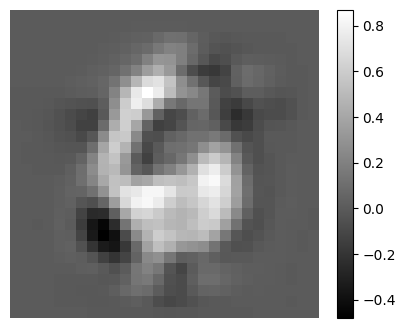

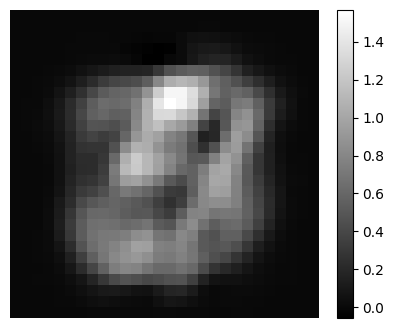

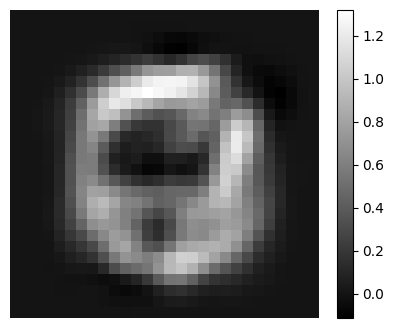

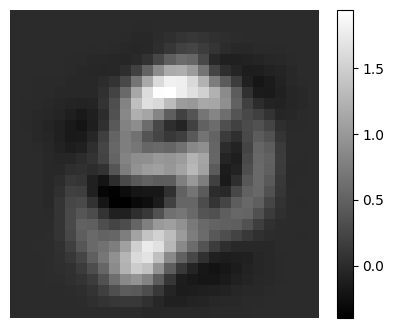

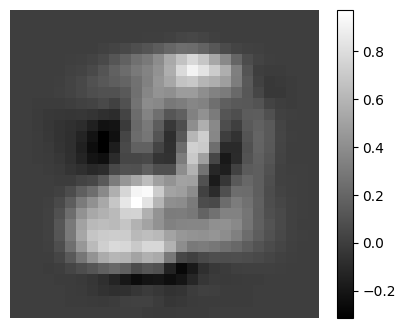

In [12]:
# Generate gaussian noise and denoise it to latent space embeddings z 
z_samples = sample(model, num_samples=5, timesteps=timesteps)

# Decode the latent space embeddings z to the original space x
x_samples = decoder(z_samples)

for i in range(x_samples.shape[0]):
    fig, ax = plt.subplots(1, 1, figsize=(5, 4))
    plot = ax.imshow(x_samples[i, :].reshape(dim1, dim2), cmap="gray",)
    ax.axis("off")
    fig.colorbar(plot)
